# I. Configuration du Projet et Initialisation de l'Environnement

Ce bloc pose le cadre organisationnel du Notebook. Il permet la centralisation de l'ensemble des paramètres nécessaires au bon déreoulement de la chaîne de traitement. 

De manière général, il définit les répertoires d'entrée et de sortie, les chemins d'accès aux différents sources de données de **la première partie du traitement***. 

**La première partie du traitement*** : correspond à l'extraction des informations nécessaires dans les données de références (BD TOPO, BD FORET, RPG et RPG COMPLETE), indispensable pour la suite du traitement.  

**Nota Bene** : 
* Pour que le code fonctionne sans intérruption, la nommenclature des données en entrée doivent être adaptés de la manière suivante : les dalles de 10km² (**ZONE.gpkg**), les parceles cadastrales (**CADASTRE.gpkg**), le RPG (**RPG_2022.gpkg**), le RPG COMPLETE (**RPG_COMPLETE_2022.gpkg**), la BD TOPO (**BD_TOPO_2025.gpkg**), la BD FORET (**FORMATION_VEGETALE_BD_FORET_2017.gpkg**). Il est possible de les modifier, mais ils doivent être adapté dans le script.
* Les Parties du code à adapter sont celles indiquées par des commentaires avec 3x le signe #. Exemple : ###.......... 

In [9]:
# Importation des bibliothèques
import os
import geopandas as gpd
from pathlib import Path

# =============================================================================
# 1. DÉFINITION DES REPERTOIRES MERES
# =============================================================================
DIR_ENTREE_SIG   = Path(r'C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/ENTRER_REFERENCE') ### Indiquer le répertoire de l'ensemble des données de références en format Géopackage 
DIR_SORTIE       = Path(r'C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/SORTIE_REFERENCE') ### Indiquer le répertoire de sortie après les traitements

# =============================================================================
# 2. CONFIGURATION GENERALE DES FLUX DE DONNÉES EN ENTREE
# =============================================================================
config = {
    # Ajout du champ attributaire "DALLE" pour assurer la traçabilité des zones
    'CHAMPS_ID': ["CODE_DEP", "NOM_COM", "CODE_COM", "SECTION", "NUMERO", "DALLE"],

    # Référentiels spatiaux de base
    'ZONE_PATH'     : DIR_ENTREE_SIG / "ZONE.gpkg", 
    'CADASTRE_PATH' : DIR_ENTREE_SIG / "CADASTRE.gpkg",

    # Configuration des chemains d'entrée (format gpkg) et de sortie (format csv) des données RPG et RPG COMPLETE & Initialisation pour leur fusion.
    'RPG_GPKG'        : DIR_ENTREE_SIG / "RPG_2022.gpkg", 
    'RPG_COMP_GPKG'   : DIR_ENTREE_SIG / "RPG_COMPLETE_2022.gpkg",
    'ANNEES_RPG'      : ["2022"], ### Spécifier l'année du RPG à fusionner avec le RPG COMPLETE
    'ANNEES_RPG_COMP' : ["2022"], ### Spécifier l'année du RPG COMPLETE à fusionner avec le RPG 
    'DIR_CSV_RPG_FUS' : DIR_SORTIE,

    # Configuration des chemins d'entrée (format gpkg) et de sortie (format csv) de la BD FORÊT (IGN)
    'FORET_PATH'       : DIR_ENTREE_SIG / "FORMATION_VEGETALE_BD_FORET_2017.gpkg",
    'DOSSIER_CSV_FORET': DIR_SORTIE,
    'ANNEES_BDFORET': ['2017'], ### Spécifier l'année du BDFORET à traiter

    # Configuration des chemins d'entrée (format gpkg) et de sortie (format csv) de la BD TOPO (IGN)
    'BDTOPO_PATH'       : DIR_ENTREE_SIG / "BDTOPO_2025.gpkg",
    'DOSSIER_CSV_BDTOPO': DIR_SORTIE,
    'ANNEES_BDTOPO' : ['2025'], ### Spécifier l'année du BDTOPO à traiter
    'COUCHES_BDTOPO'    : [
        "BATIMENT", "CIMETIERE", "CONSTRUCTION_SURFACIQUE",
        "SURFACE_HYDROGRAPHIQUE", "RESERVOIR", "TERRAIN_DE_SPORT",
        "ZONE_D_ESTRAN"
    ]
}

# =============================================================================
# 3. INITIALISATION DE L'ARBORESCENCE DES DOSSIERS EN SORTIE
# =============================================================================
dossiers_requis = [
    DIR_SORTIE,
    config['DIR_CSV_RPG_FUS'],
    config['DOSSIER_CSV_FORET'],
    config['DOSSIER_CSV_BDTOPO']
]

for dossier in dossiers_requis:
    dossier.mkdir(parents=True, exist_ok=True)

print("Environnement initialisé : Prêt pour le traitement.")

Environnement initialisé : Prêt pour le traitement.


# II. Extraction du Référentiel Parcellaire (Cadastre)
Ce bloc permet d'extraire le référentiel cadastral strcitement limité aux emprises d'étude, afin d'optimer les performances de calcul. 

Pour ce faire, une jointure spatiale est réalisé entre les parcelles cadastrales et les dalles de 10 km², permettant d'affecter à chaque entité parcellaire un identifiant spatial structurant (`DALLE`). 

In [2]:
# --- CHAREGEMENT DES EMPRISES D'ETUDES ET DECOUPAGE DU CADASTRE ---

print("Chargement des emprises et extraction du cadastre...")

gdf_zone = gpd.read_file(config['ZONE_PATH'])

# Chargement du cadastre avec le masque de la zone
gdf_parcelles = gpd.read_file(
    config['CADASTRE_PATH'],
    mask=gdf_zone,
    engine='pyogrio'
)

# --- JOINTURE SPATIALE POUR INTEGRER LE NUMÉRO DE DALLE AUX PARCELLES CADASTRALES ---

# On récupère l'attribut 'DALLE' de la zone pour l'injecter dans les parcelles
gdf_parcelles = gpd.sjoin(gdf_parcelles, gdf_zone[['DALLE', 'geometry']], how='left', predicate='intersects')

# Nettoyage de l'index de jointure 
if 'index_right' in gdf_parcelles.columns:
    gdf_parcelles = gdf_parcelles.drop(columns='index_right')

print(f"Référentiel prêt : {len(gdf_parcelles)} parcelles chargées avec leur numéro de DALLE.")

Chargement des emprises et extraction du cadastre...
Référentiel prêt : 6792 parcelles chargées avec leur numéro de DALLE.


# III. Intégration du Référentiel BD FORÊT (IGN)

Ce bloc permet d'identifier et de qualifier les parcelles relevant des classes thématiques **"BOIS"** et **"NATURE"** de la BD FORET définies lors de l'étape de la correspondance des nommenclatures. 

Le fichier CSV en sortie se présente de la manière ci-dessous, avec comme statistiques calculés : 
* **La proportion de surface (en %)** occupée par chaque classe thématiques dans la pracelle ;
* **Le nom de la classe thématique dominante** dans la parcelle ;
* **Le dégré de fiabilité (en %)** de la classe thématique dominante : qui est de 100% lorsque la classe thématique dominante est soit "BOIS" ou "NATURE" (car c'est une donnée de référence nationale) et 0% lorsqu'il y a une autre chose en dominance que ces deux classes thématiques.
* **La surface totale (en m²)** de la parcelle (`SURF_TOTALE_M2`).

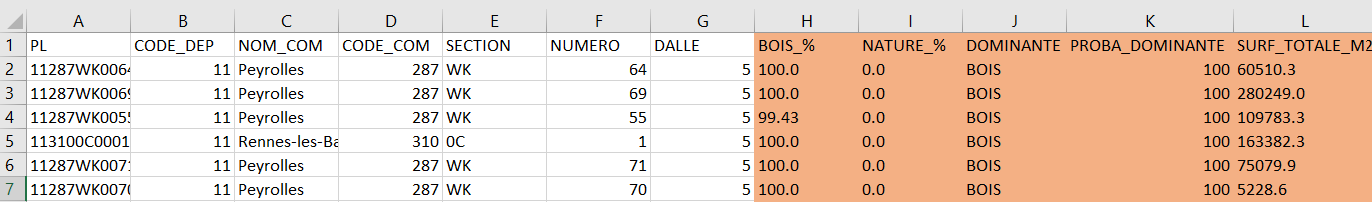

In [13]:
# Importation des bibliothèques
import pandas as pd
import geopandas as gpd
import numpy as np

print("Analyse de la BD FORET...........")

# paramétrage et initialisation
ANNEES_BDFORET = config['ANNEES_BDFORET']
C_ID = config['CHAMPS_ID']
for col in C_ID:
    if col in gdf_parcelles.columns:
        gdf_parcelles[col] = gdf_parcelles[col].astype(str).str.strip()

try:
    lyr_foret = gpd.read_file(
        config['FORET_PATH'],
        layer="FORMATION_VEGETALE_BD_FORET_2017",
        mask=gdf_parcelles,
        engine='pyogrio'
    )
    if lyr_foret.crs != gdf_parcelles.crs:
        lyr_foret = lyr_foret.to_crs(gdf_parcelles.crs)
    
    # Nettoyage géométrique pour éviter les erreurs d'intersection
    lyr_foret['geometry'] = lyr_foret.geometry.make_valid()

except Exception as e:
    print(f"ERREUR : Impossible de charger la couche Foret : {e}")
    lyr_foret = None

for annee in ANNEES_BDFORET:
    print(f"\n>>> Traitement de l'année : {annee}")
    
if lyr_foret is not None:
    inter = gpd.overlay(lyr_foret, gdf_parcelles[C_ID + ['geometry']], how='intersection')

    if not inter.empty:
        for col in C_ID:
            inter[col] = inter[col].astype(str).str.strip()

        inter['S_INT'] = inter.geometry.area

        # Classification des entités en "BOIS" ou "NATURE"
        def classifier_tfv(tfv):
            tfv_str = str(tfv).lower()
            if any(kw in tfv_str for kw in ["lande", "herbacée", "formation arbustive"]): 
                return "NATURE"
            else: 
                return "BOIS"

        inter['CLASSE_NOM'] = inter['TFV'].apply(classifier_tfv)

        # Agrégation par parcelle
        stats = inter.groupby(C_ID + ['CLASSE_NOM'])['S_INT'].sum().reset_index()
        df_res = stats.pivot_table(index=C_ID, columns='CLASSE_NOM', values='S_INT').fillna(0)

        # Calcul des indicateurs
        classes_foret = ["BOIS", "NATURE"]
        for cl in classes_foret:
            if cl not in df_res.columns: df_res[cl] = 0.0

        df_res = df_res.reset_index()

        for col in C_ID:
            df_res[col] = df_res[col].astype(str).str.strip()

        # Fusion avec le cadastre complet pour ne perdre aucune parcelle
        surf_tot = gdf_parcelles[C_ID + ['geometry']].copy()
        df_res = pd.merge(df_res, surf_tot, on=C_ID, how='right').fillna(0)
        
        # Conversion en GeoDataFrame pour calculer la surface réelle de la parcelle
        df_res = gpd.GeoDataFrame(df_res, geometry='geometry', crs=gdf_parcelles.crs)
        df_res['SURF_TOTALE_M2'] = df_res.geometry.area.round(1)

        # Calcul des proportions (en %) occupées par chaque classe dans la parcelle 
        for cl in classes_foret:
            df_res[f"{cl}_%"] = ((df_res[cl] / df_res['SURF_TOTALE_M2']) * 100).round(2)

        surf_foret_totale = df_res[classes_foret].sum(axis=1)

        # Détermination de la classe DOMINANTE ou AUTRE si la parcelle ne contient pas les classes thématiques définies
        df_res['DOMINANTE'] = np.where(
            surf_foret_totale > 0,
            df_res[[f"{cl}_%" for cl in classes_foret]].idxmax(axis=1).str.replace('_%', ''),
            "AUTRE"
        )

        # Calcul des probabilité : 100 quand les classes "NATURE" et "BOIS" sont présents dans la parcelle et 0 quand il y a autre chose que ces classes
        df_res['PROBA_DOMINANTE'] = np.where(df_res['DOMINANTE'] == "AUTRE", 0, 100)

        # Génération du champ 'PL' (identification unique de chaque parcelle) 
        df_res['PL'] = (
            df_res['CODE_DEP'].astype(str).str.zfill(2) +
            df_res['CODE_COM'].astype(str).str.zfill(3) +
            df_res['SECTION'].astype(str).str.zfill(2) +
            df_res['NUMERO'].astype(str).str.zfill(4)
        )

        # Exportation des résultats en format CSV
        output_csv = config['DOSSIER_CSV_FORET'] / f"STAT_PARCELLE_BDFORET_{annee}.csv"
        cols_finales = ['PL'] + C_ID + [f"{cl}_%" for cl in classes_foret] + \
                       ["DOMINANTE", "PROBA_DOMINANTE", "SURF_TOTALE_M2"]

        df_res[cols_finales].to_csv(output_csv, sep=';', index=False, encoding='utf-8')

print("TRAITEMENT BD FORET TERMINÉ.")

Analyse de la BD FORET...........

>>> Traitement de l'année : 2017
TRAITEMENT BD FORET TERMINÉ.


# IV. Intégration du Référentiel BD TOPO (IGN)

Ce bloc permet d'identifier et de qualifier les parcelles relevant des classes thématiques **"ARTIFICIALISE"**, **"NATURE"** et **"EAU"** de la BD TOPO définies lors de l'étape de la correspondance des nommenclatures. 

Le fichier CSV en sortie se présente de la manière ci-dessous, avec comme statistiques calculés : 
* **La proportion de surface (en %)** occupée par chaque classe thématiques dans la pracelle ;
* **Le nom de la classe thématique dominante** dans la parcelle ;
* **Le dégré de fiabilité (en %)** de la classe thématique dominante : qui est de 100% lorsque la classe thématique dominante est soit "ARTIFICIALISE", "NATURE" ou "EAU" (car considéré comme référence nationale) et 0% lorsqu'il y a une autre chose que ces trois classes thématiques ;
* **La surface totale (en m²)** de la parcelle (`SURF_TOTALE_M2`).

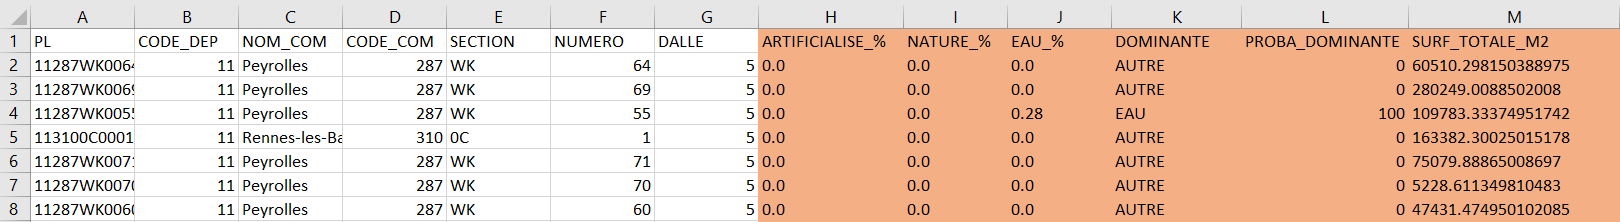

In [11]:
# Importation des bibliothèques
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

print("Analyse de la BD TOPO...........")

# Paramétrage et initialisation
C_ID = config['CHAMPS_ID']
ANNEES_BDTOPO = config['ANNEES_BDTOPO']
TOPO_PATH = config['BDTOPO_PATH']
OUT_DIR = config['DOSSIER_CSV_BDTOPO']

if 'gdf_parcelles' not in locals():
    raise EnvironmentError("Référentiel 'gdf_parcelles' absent. Exécuter le Module I.")

# Définition des classes cibles
classes_list = ["ARTIFICIALISE","NATURE","EAU"]

df_travail = gdf_parcelles[C_ID + ['geometry']].copy()
for col in C_ID:
    df_travail[col] = df_travail[col].astype(str).str.strip()

for cl in classes_list:
    df_travail[cl] = 0.0

# Définition du Mapping
mapping_layers = {
    'BATIMENT': 'ARTIFICIALISE',
    'CIMETIERE': 'ARTIFICIALISE',
    'CONSTRUCTION_SURFACIQUE': 'ARTIFICIALISE',
    'TERRAIN_DE_SPORT': 'ARTIFICIALISE',
    'SURFACE_HYDROGRAPHIQUE': 'EAU',
    'RESERVOIR': 'ARTIFICIALISE',
    'ZONE_D_ESTRAN': 'NATURE'
}

# Traitement du Mapping (Intersection)
for annee in ANNEES_BDTOPO:
    print(f"\n>>> Traitement de l'année : {annee}")
    
for layer_name, cat in mapping_layers.items():
    try:
        print(f"    > Intersection spatiale : {layer_name}")
        lyr_topo = gpd.read_file(TOPO_PATH, layer=layer_name, mask=gdf_parcelles, engine='pyogrio')

        if not lyr_topo.empty:
            if lyr_topo.crs != df_travail.crs:
                lyr_topo = lyr_topo.to_crs(df_travail.crs)

            lyr_topo['geometry'] = lyr_topo.geometry.make_valid()
            
            # Intersection spatiale
            inter = gpd.overlay(df_travail[C_ID + ['geometry']], lyr_topo, how='intersection')
            
            if not inter.empty:
                for col in C_ID:
                    inter[col] = inter[col].astype(str).str.strip()
                
                inter['S_INT'] = inter.geometry.area
                
                # Agrégation des surfaces
                sums = inter.groupby(C_ID)['S_INT'].sum()

                df_travail.set_index(C_ID, inplace=True)
                df_travail[cat] = df_travail[cat].add(sums, fill_value=0)
                df_travail.reset_index(inplace=True)
                
    except Exception as e:
        print(f" ! Information : Couche {layer_name} non traitée ou absente : {e}")

#  Calcul des indicateurs
print("    > Consolidation des indicateurs statistiques...")

df_travail['SURF_TOTALE_M2'] = df_travail.geometry.area

# Calcul des pourcentages
for cl in classes_list:
    df_travail[f"{cl}_%"] = ((df_travail[cl] / df_travail['SURF_TOTALE_M2']) * 100).round(2)

# Détermination de la classe DOMINANTE ou AUTRE si la parcelle ne contient pas les classes thématiques définies
surf_topo_identifiee = df_travail[classes_list].sum(axis=1)
df_travail['DOMINANTE'] = np.where(
    surf_topo_identifiee > 0,
    df_travail[classes_list].idxmax(axis=1),
    "AUTRE"
)

# Calcul des probabilité : 100 quand les classes "ARTIFICIALISE", "NATURE" et "EAU" sont présents dans la parcelle et 0 quand il y a autre chose que ces classes
df_travail['PROBA_DOMINANTE'] = np.where(df_travail['DOMINANTE'] == "AUTRE", 0, 100)

# Génération du champ 'PL' (identification unique de chaque parcelle) 
df_travail['PL'] = (
    df_travail['CODE_DEP'].astype(str).str.zfill(2) +
    df_travail['CODE_COM'].astype(str).str.zfill(3) +
    df_travail['SECTION'].astype(str).str.zfill(2) +
    df_travail['NUMERO'].astype(str).str.zfill(4)
)

 # Exportation des résultats en format CSV
output_path = Path(OUT_DIR) / f"STAT_PARCELLE_BDTOPO_{annee}.csv"
cols_export = ['PL'] + C_ID + [f"{cl}_%" for cl in classes_list] + ["DOMINANTE", "PROBA_DOMINANTE", "SURF_TOTALE_M2"]
df_travail[cols_export].to_csv(output_path, sep=';', index=False, encoding='utf-8')

print("TRAITEMENT BD TOPO TERMINÉ")

Analyse de la BD TOPO...........

>>> Traitement de l'année : 2025
    > Intersection spatiale : BATIMENT


C:\Users\angee\anaconda3\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


    > Intersection spatiale : CIMETIERE
    > Intersection spatiale : CONSTRUCTION_SURFACIQUE
    > Intersection spatiale : TERRAIN_DE_SPORT
    > Intersection spatiale : SURFACE_HYDROGRAPHIQUE
    > Intersection spatiale : RESERVOIR
    > Intersection spatiale : ZONE_D_ESTRAN
    > Consolidation des indicateurs statistiques...
TRAITEMENT BD TOPO TERMINÉ


# IV. Intégration du Référentiel RPG FUSIONNE (RPG + RPG COMPLETE)

Ce bloc permet d'identifier et de qualifier les parcelles relevant des classes thématiques **"ARTIFICIALISE"**, **"AGRICULTURE"** et **"NATURE"** du RPG et RPG COMPLETE définies lors de l'étape de la correspondance des nommenclatures, avant de fusionner (RPG FUSIONNE) les entités entre elles selon leur classe thématique.

Le fichier CSV en sortie se présente de la manière ci-dessous, avec comme statistiques calculés : 
* **La proportion de surface (en %)** occupée par chaque classe thématiques dans la pracelle ;
* **Le nom de la classe thématique dominante** dans la parcelle ;
* **Le dégré de fiabilité (en %)** de la classe thématique dominante : qui est de 100% lorsque la classe thématique dominante est soit "ARTIFICIALISE", "AGRICULTURE" ou "NATURE" (car considéré comme référence nationale) et 0% lorsqu'il y a une autre chose que ces trois classes thématiques ;
* **La surface totale (en m²)** de la parcelle (`SURF_CAD`).

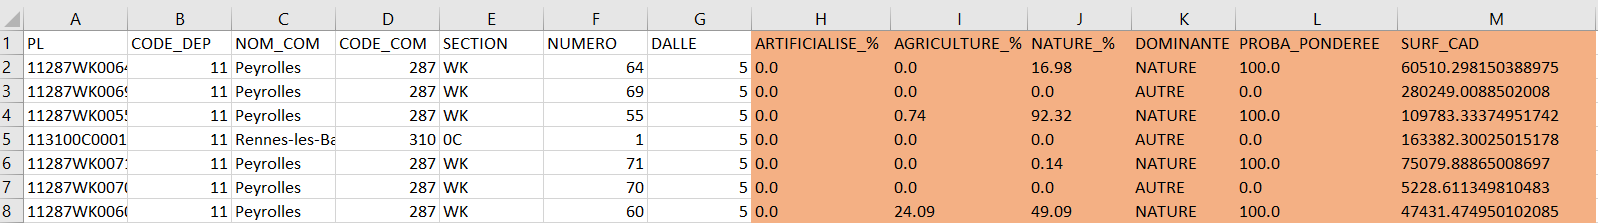

In [15]:
# Importation des bibliothèques
import geopandas as gpd
import numpy as np
from pathlib import Path

print("Démarage de la fusion des RPG et Analyse...........")

# Paramétrage et initialisation
C_ID = config['CHAMPS_ID']
ANNEES_RPG = config['ANNEES_RPG']
PATH_RPG_STD = config['RPG_GPKG']
PATH_RPG_COMP = config['RPG_COMP_GPKG']
DIR_FUSION = config['DIR_CSV_RPG_FUS']

# Définition des classes cibles
CLASSES_CIBLES = ["ARTIFICIALISE","AGRICULTURE","NATURE"]

def reclass_unifie(row, est_std):
    if est_std:
        # CAS 1 : RPG (Mappin selon l'attribut "CODE_GROUP") 
        try:
            val = row.get("CODE_GROUP", 0)
            grp = int(val) if val is not None else 0
        except (ValueError, TypeError):
            grp = 0
            
        if grp == 17: return "NATURE"
        return "AGRICULTURE"
        
    else:
        # CAS 2 : RPG COMPLETE (Mapping selon l'attribut "culture")
        label = str(row.get("culture", ""))
        if not label or label == "None":
            return "AUTRE"
        
        l_low = label.lower()
        
        if "jardin collectif" in l_low: return "ARTIFICIALISE"
        if "landes" in l_low: return "NATURE"
        if "landes (pelouses)" in l_low: return "NATURE"    
        
        return "AGRICULTURE"

# Fusion du RPG et RPG COMPLETE
for annee in ANNEES_RPG:
    print(f"\n>>> Traitement de l'annuité : {annee}")

    df_bilan = gdf_parcelles[C_ID + ['geometry']].copy()
    for col in C_ID:
        df_bilan[col] = df_bilan[col].astype(str).str.strip()
    
    df_bilan['SURF_CAD'] = df_bilan.geometry.area

    for cl in CLASSES_CIBLES:
        df_bilan[f"{cl}_s"] = 0.0
        df_bilan[f"{cl}_p"] = 0.0

    def traiter_source(path, layer_name, est_std):
        global df_bilan
        try:
            lyr_src = gpd.read_file(path, layer=layer_name, mask=gdf_parcelles, engine='pyogrio')
            if lyr_src.empty: return

            if lyr_src.crs != df_bilan.crs:
                lyr_src = lyr_src.to_crs(df_bilan.crs)

            lyr_src['geometry'] = lyr_src.geometry.make_valid()
            inter = gpd.overlay(lyr_src, df_bilan[C_ID + ['geometry']], how='intersection')
            
            if inter.empty: return

            for col in C_ID:
                inter[col] = inter[col].astype(str).str.strip()
                
            inter['S_INT'] = inter.geometry.area
            inter['CLASSE_UNIF'] = inter.apply(lambda r: reclass_unifie(r, est_std), axis=1)

            if not est_std and 'proba' in inter.columns:
                p_raw = inter['proba'].astype(str).str.replace(',', '.').astype(float).fillna(0.0)
                inter['p_val'] = np.where(p_raw <= 1.0, p_raw * 100.0, p_raw)
            else:
                inter['p_val'] = 100.0

            inter['P_POND'] = inter['S_INT'] * inter['p_val']

            for cl in CLASSES_CIBLES:
                mask_cl = inter['CLASSE_UNIF'] == cl
                if mask_cl.any():
                    subset = inter[mask_cl].groupby(C_ID).agg({'S_INT': 'sum', 'P_POND': 'sum'})
                    df_bilan = df_bilan.set_index(C_ID)
                    df_bilan[f"{cl}_s"] = df_bilan[f"{cl}_s"].add(subset['S_INT'], fill_value=0)
                    df_bilan[f"{cl}_p"] = df_bilan[f"{cl}_p"].add(subset['P_POND'], fill_value=0)
                    df_bilan = df_bilan.reset_index()
                    
        except Exception as e:
            print(f"   ! Erreur technique sur {layer_name} : {e}")

    traiter_source(PATH_RPG_STD, f"RPG_{annee}", est_std=True)
    traiter_source(PATH_RPG_COMP, f"RPG_COMPLETE_{annee}", est_std=False)

    for cl in CLASSES_CIBLES:
        df_bilan[f"{cl}_%"] = ((df_bilan[f"{cl}_s"] / df_bilan['SURF_CAD']) * 100).round(2)

    surf_rpg_tot = df_bilan[[f"{cl}_s" for cl in CLASSES_CIBLES]].sum(axis=1)
    
    # Détermination de la classe DOMINANTE ou AUTRE si la parcelle ne contient pas les classes thématiques définies
    df_bilan['DOMINANTE'] = np.where(
        surf_rpg_tot > 0,
        df_bilan[[f"{cl}_s" for cl in CLASSES_CIBLES]].idxmax(axis=1).str.replace('_s', ''),
        "AUTRE"
    )

    # Calcul des probabilité : 100 quand les classes "ARTIFICIALISE", "NATURE" et "EAU" sont présents dans la parcelle et 0 quand il y a autre chose que ces classes
    def calculer_proba(row):
        dom = row['DOMINANTE']
        if dom == "AUTRE": return 0.0
        return round(row[f"{dom}_p"] / row[f"{dom}_s"], 1) if row[f"{dom}_s"] > 0 else 0.0

    df_bilan['PROBA_PONDEREE'] = df_bilan.apply(calculer_proba, axis=1)

    df_bilan['PL'] = (
        df_bilan['CODE_DEP'].astype(str).str.zfill(2) +
        df_bilan['CODE_COM'].astype(str).str.zfill(3) +
        df_bilan['SECTION'].astype(str).str.zfill(2) +
        df_bilan['NUMERO'].astype(str).str.zfill(4)
    )

    path_out = Path(DIR_FUSION) / f"STAT_RPG_SYNTHESE_{annee}.csv"
    cols_export = ['PL'] + C_ID + [f"{cl}_%" for cl in CLASSES_CIBLES] + ["DOMINANTE", "PROBA_PONDEREE", "SURF_CAD"]
    
    df_bilan[cols_export].to_csv(path_out, sep=';', index=False, encoding='utf-8')

print("TRAITEMENT RPG FUSIONNE TERMINÉ")

Démarage de la fusion des RPG et Analyse...........

>>> Traitement de l'annuité : 2022
TRAITEMENT RPG FUSIONNE TERMINÉ


## V. Intégration des coéfficients au dégré de fiabilité (probabilité) de chaque source de donnée : OSO, COSIA, BD FORET, BD TOPO, RPG FUSIONNE

In [ ]:
# Importation des bibliothèque
import pandas as pd
import os

# Initialisation : indication du chemin d'entrée des données et de sortie
repertoire_donnees = r"C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/SORTIE_REFERENCE"
repertoire_sortie = r"C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/SORTIE_REFERENCE/SORTIE_REFERENCE_VERSION_FINALE"

# Création du dossier de sortie s'il n'existe pas
if not os.path.exists(repertoire_sortie):
    os.makedirs(repertoire_sortie)

# Définition des règles de correction (Voir Coefficient Source)
regles_correction = {
    "STAT_PARCELLES_BDTOPO_2025.csv": ("PROBA_DOMINANTE", 0.950),
    "STAT_PARCELLES_FORET_2017.csv":  ("PROBA_DOMINANTE", 0.927),
    "STAT_RPG_SYNTHESE_2022.csv":     ("PROBA_PONDEREE", 0.955),
    "SYNTHESE_OSO_FREQUENCE.csv":     ("PROBA_MOY_ELU", 0.830),
    "SYNTHESE_COSIA_FREQUENCE.csv":   ("PROBA_MOYENNE", 0.835)
}

print("Démarage du traitement des fichiers.............")

# Boucle de traitement
for fichier, (colonne, coefficient) in regles_correction.items():
    chemin_entree = os.path.join(repertoire_donnees, fichier)
    
    if os.path.exists(chemin_entree):
        try:
            
            df = pd.read_csv(chemin_entree, sep=';', encoding='utf-8')
            
            if colonne in df.columns:
                print(f"Traitement de {fichier} (Correction de {colonne} par {coefficient})...")
                
                df[colonne] = pd.to_numeric(
                    df[colonne].astype(str).str.replace(',', '.'), 
                    errors='coerce'
                ).fillna(0.0)
                
                df[colonne] = (df[colonne] * coefficient).round(3)
                
                # Sauvegarde du fichier 
                chemin_sortie = os.path.join(repertoire_sortie, f"FINALE_{fichier}")
                df.to_csv(chemin_sortie, sep=';', index=False, encoding='utf-8')
                print(f"   -> Enregistré sous : {os.path.basename(chemin_sortie)}")
            else:
                print(f"⚠️ Attention : Colonne '{colonne}' introuvable dans {fichier}")
                
        except Exception as e:
            print(f"❌ Erreur lors du traitement de {fichier} : {e}")
    else:
        print(f"❌ Fichier non trouvé : {fichier}")

print("TRAITEMENT TERMINÉ")

# VI. ARBRE DE DECISION

Ce bloc permet de mettre à jour l’attribut "Occupation du Sol" (OS) des parcelles cadastrales, en s’appuyant sur un ensemble cohérent de données multisources, libre de droit tels que la donnée OSO (THEIA), COSIA (IGN), BD FORET (IGN), BD TOPO (IGN), RPG  et RPG COMPLETE (IGN). 

La méthodologie employée se base sur un Arbre de décision (figure ci-dessous) à plusieurs branches, permettant de traiter toute les possibilités. Cela permet une reproductibilité et une généralisation de la méthode proposée sur d’autres territoires français. 

Le fichier CSV en sortie se présente de la manière ci-dessous, avec comme statistiques calculés : 
* **La classification finale** (classe thématique unique) de la parcelle ;
* **Le score de confiance (en %)** associé à la classification parcellaire ;
* **Le nom de(s) source(s)** ayant contribuée(s) à classer une parcelle donnée ;
* **Le dégré de fiabilité  (en %)** de(s) source(s) ayant contribuée(s) à classer une parcelle donnée.

En fonction de la décision prise par chaque branche de l'Arbre : 

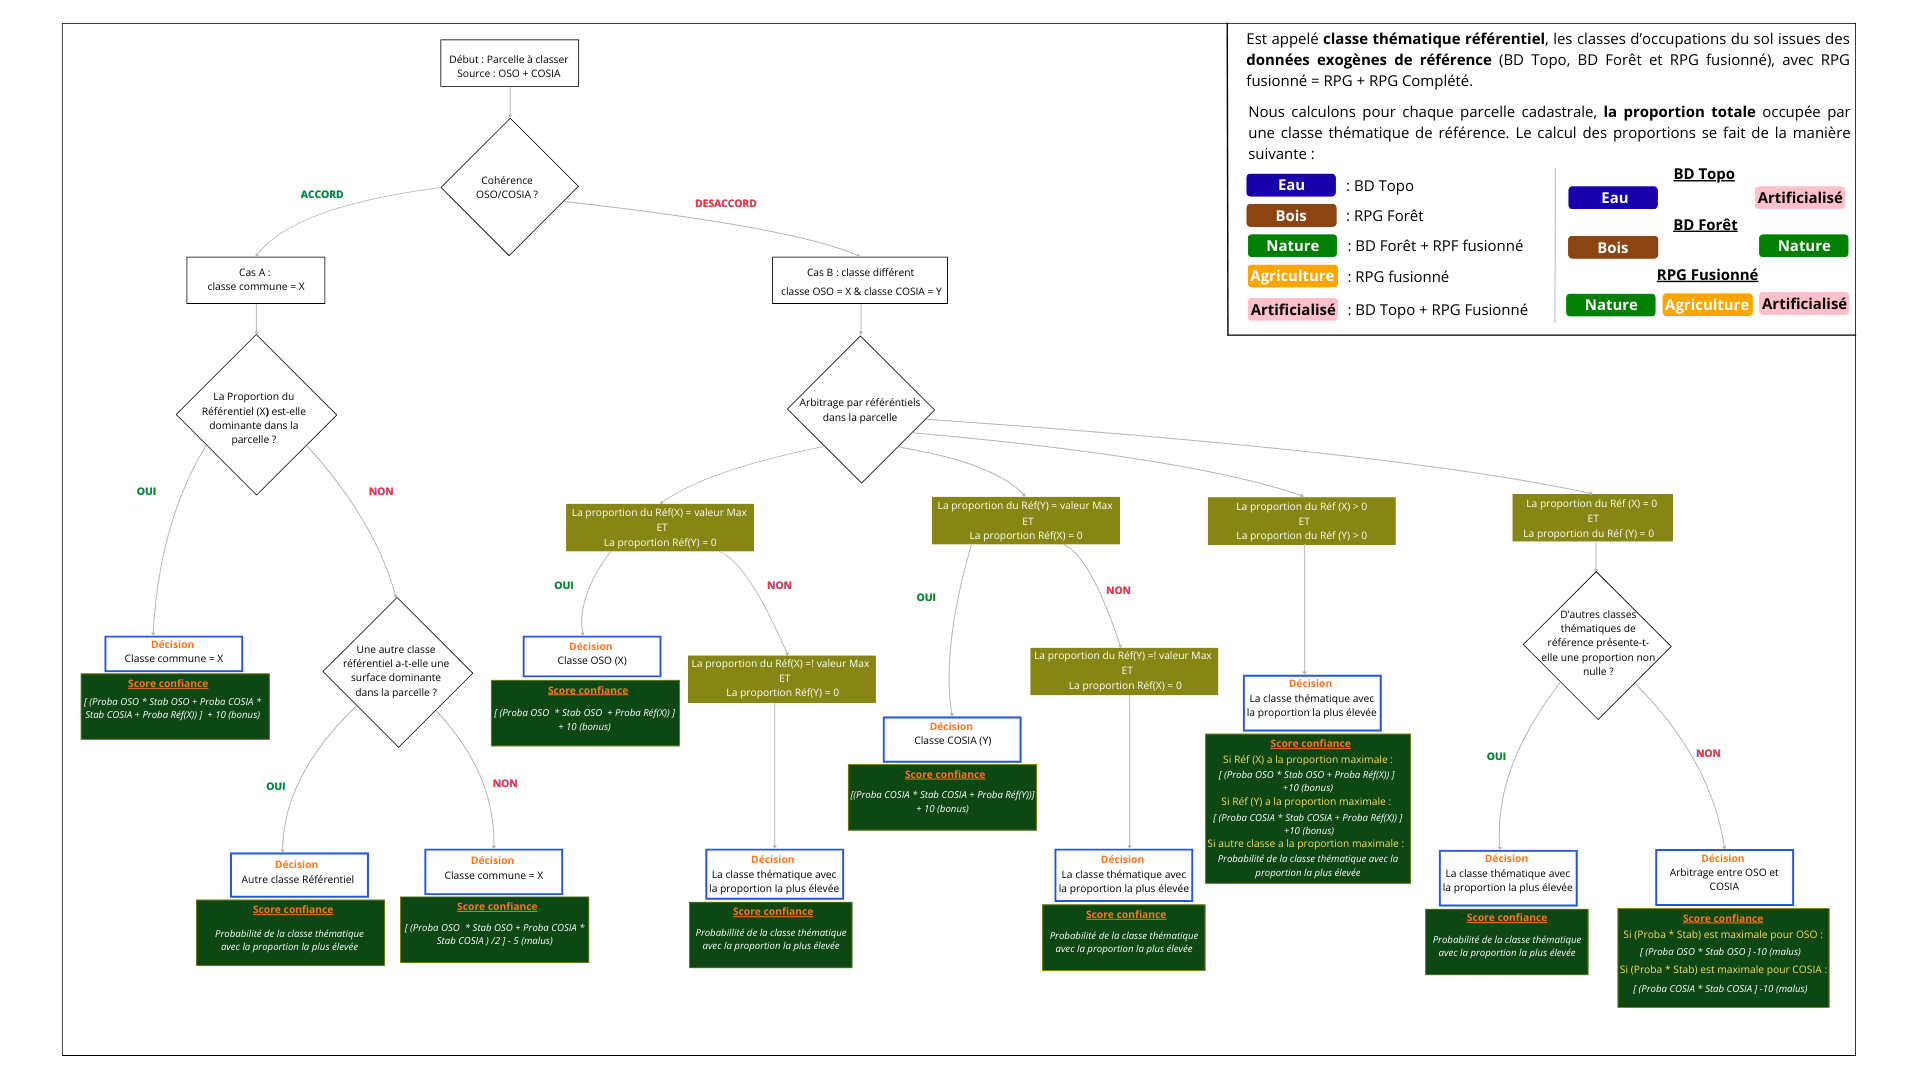

En fonction de la décision prise par les branches de l'ARbre, **le score de confiance (en %)*** de la classification parcellaire est calculé selon les principes suivants : 

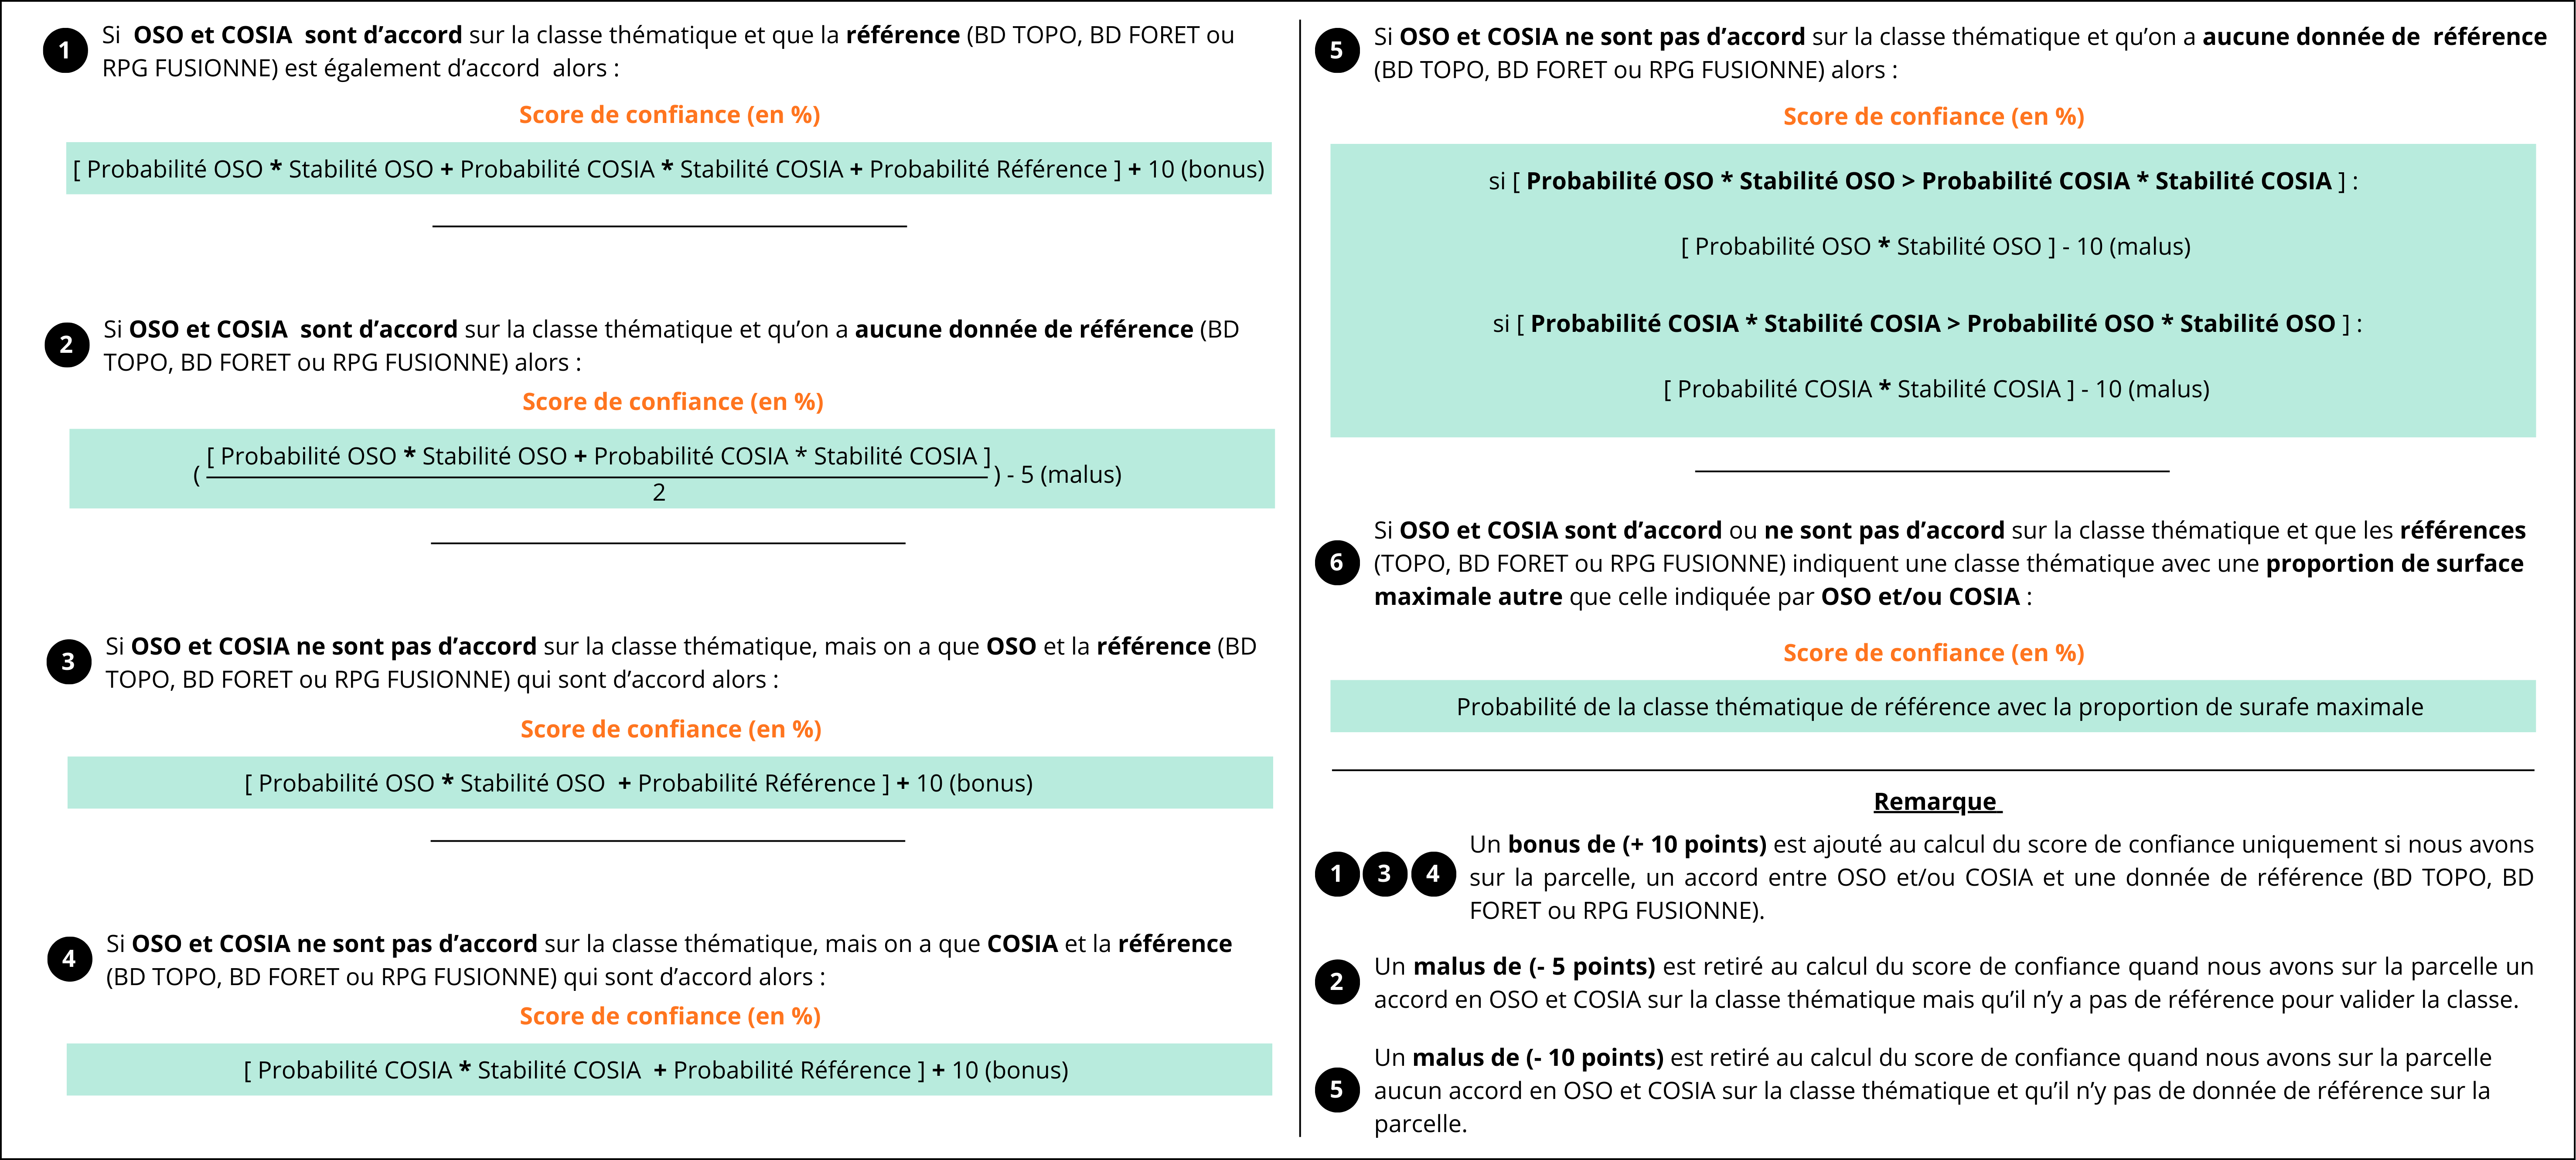

In [ ]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import os

# Initialisation : indication du chemin d'entrée des données et de sortie
chemin_entree = r"C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/SORTIE_REFERENCE/SORTIE_REFERENCE_VERSION_FINALE"
chemin_sortie = r'C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/CLASSIFICATION_FINALE/SORTIE'

# Création du dossier de sortie s'il n'existe pas
if not os.path.exists(chemin_sortie):
    os.makedirs(chemin_sortie)
    
# Chargement des fichiers et renommage des noms attributaires pour éviter les erreurs
try:
    df_oso = pd.read_csv(os.path.join(chemin_entree, 'FINALE_SYNTHESE_OSO_FREQUENCE.csv'), sep=';')
    df_oso = df_oso.rename(columns={'PROBA_MOY_ELU': 'PROBA_MOYENNE_OSO'})

    df_cosia = pd.read_csv(os.path.join(chemin_entree, 'FINALE_SYNTHESE_COSIA_FREQUENCE.csv'), sep=';')
    df_cosia = df_cosia.rename(columns={'PROBA_MOYENNE': 'PROBA_MOYENNE_COSIA'})

    df_topo = pd.read_csv(os.path.join(chemin_entree, 'FINALE_STAT_PARCELLES_BDTOPO_2025.csv'), sep=';')
    df_topo = df_topo.rename(columns={
        'ARTIFICIALISE_%': 'ARTIF_TOPO',
        'EAU_%': 'EAU_TOPO',
        'DOMINANTE': 'DOM_TOPO',
        'PROBA_DOMINANTE': 'PROBA_TOPO'
    })

    df_foret = pd.read_csv(os.path.join(chemin_entree, 'FINALE_STAT_PARCELLES_FORET_2017.csv'), sep=';')
    df_foret = df_foret.rename(columns={
        'BOIS_%': 'BOIS_FORET',
        'NATURE_%': 'NATURE_FORET',
        'DOMINANTE': 'DOM_FORET',
        'PROBA_DOMINANTE': 'PROBA_FORET'
    })

    df_rpg = pd.read_csv(os.path.join(chemin_entree, 'FINALE_STAT_RPG_SYNTHESE_2022.csv'), sep=';')
    df_rpg = df_rpg.rename(columns={
        'ARTIFICIALISE_%': 'ARTIF_RPG',
        'AGRICULTURE_%': 'AGRI_RPG',
        'NATURE_%': 'NATURE_RPG',
        'DOMINANTE': 'DOM_RPG',
        'PROBA_PONDEREE': 'PROBA_RPG'
    })

    print("Tous les fichiers ont été chargés avec succès depuis le répertoire local.")
except Exception as e:
    print(f"Erreur lors du chargement : {e}")

# Fusion des données
clés = ['PL', 'CODE_DEP', 'NOM_COM', 'SECTION', 'NUMERO', 'DALLE']

# Fusion OSO + COSIA
df = pd.merge(df_oso, df_cosia, on=clés, how='inner', suffixes=('_OSO', '_COSIA'))

# Fusion avec les référentiels
df = pd.merge(df, df_topo[clés + ['ARTIF_TOPO', 'EAU_TOPO', 'DOM_TOPO', 'PROBA_TOPO']], on=clés, how='left')
df = pd.merge(df, df_foret[clés + ['BOIS_FORET', 'NATURE_FORET', 'DOM_FORET', 'PROBA_FORET']], on=clés, how='left')
df = pd.merge(df, df_rpg[clés + ['ARTIF_RPG', 'AGRI_RPG', 'NATURE_RPG', 'DOM_RPG', 'PROBA_RPG']], on=clés, how='left')

# Standarisation du score de stabilité
df = df.fillna(0)
df['STAB_OSO'] = df['SCORE_STABILITE_OSO'] / 100
df['STAB_COSIA'] = df['SCORE_STABILITE_COSIA'] / 100

# Calcul des proportion totale des classes thématiques
df['Prop_ARTIFICIALISE'] = df['ARTIF_TOPO'] + df['ARTIF_RPG']
df['Prop_AGRICULTURE'] = df['AGRI_RPG']
df['Prop_EAU'] = df['EAU_TOPO']
df['Prop_BOIS'] = df['BOIS_FORET']
df['Prop_NATURE'] = df['NATURE_RPG'] + df['NATURE_FORET']

# Mapping pour l'Arbre
rev_prop_map = {
    'Prop_ARTIFICIALISE': 'ARTIFICIALISE', 'Prop_AGRICULTURE': 'AGRICULTURE',
    'Prop_EAU': 'EAU', 'Prop_BOIS': 'BOIS', 'Prop_NATURE': 'NATURE'
}

# Fonction pour trouver la probabilité de la classe dominante choisie dans les réf
def get_ref_name(row, classe_max):
    if classe_max == 'ARTIFICIALISE': return "BD TOPO"
    if classe_max == 'EAU': return "BD TOPO"
    if classe_max == 'AGRICULTURE': return "RPG"
    if classe_max == 'BOIS': return "BD FORET"
    if classe_max == 'NATURE':
        # On regarde lequel a la proba la plus haute pour Nature
        return "RPG" if row['PROBA_RPG'] >= row['PROBA_FORET'] else "BD FORET"
    return "REF"

def get_ref_proba(row, classe_max):
    if classe_max == 'ARTIFICIALISE': return row['PROBA_TOPO']
    if classe_max == 'EAU': return row['PROBA_TOPO']
    if classe_max == 'AGRICULTURE': return row['PROBA_RPG']
    if classe_max == 'BOIS': return row['PROBA_FORET']
    if classe_max == 'NATURE': return max(row['PROBA_RPG'], row['PROBA_FORET'])
    return 0

# Décision de l'Arbre
def decision_tree(row):
    oso_raw = str(row['DOM_OSO_FINALE']).upper()
    cosia_raw = str(row['COSIA_CLASSE_FINALE']).upper()

    # Harmonisation des noms de classe 
    X = 'AGRICULTURE' if oso_raw == 'AGRICOLE' else oso_raw
    Y = 'AGRICULTURE' if cosia_raw == 'AGRICOLE' else cosia_raw

    # Dominante Référentiel
    props = {c: row[c] for c in rev_prop_map.keys()}
    col_max = max(props, key=props.get)
    val_max = props[col_max]
    classe_max_ref = rev_prop_map[col_max]
    proba_ref_max = get_ref_proba(row, classe_max_ref)

    # CAS A : ACCORD OSO (X) = COSIA (Y)
    if X == Y:
        X = X
        prop_X = props.get(X, 0)
        proba_ref_X = get_ref_proba(row, X)

        # Est que la Proportion du Réf(X) est dominante ?
        if X == classe_max_ref and val_max > 0:
            final_class = X
            score = (row['PROBA_MOYENNE_OSO'] * row['STAB_OSO'] + row['PROBA_MOYENNE_COSIA'] * row['STAB_COSIA'] + proba_ref_X) + 10
            sources = f"OSO, COSIA, {get_ref_name(row, X)}" 
        else:
            # Une autre classe référentiel est-elle dominante ?
            if val_max > 0:
                final_class = classe_max_ref
                score = proba_ref_max # Probabilité de la classe thématique avec la proportion la plus élevée
                sources = get_ref_name(row, classe_max_ref)
            else:
                # Aucune donnée référentiel dans la parcelle
                final_class = X
                score = ((row['PROBA_MOYENNE_OSO'] * row['STAB_OSO'] + row['PROBA_MOYENNE_COSIA'] * row['STAB_COSIA']) / 2) - 5
                sources = "OSO, COSIA"

    # DÉSACCORD OSO (X) != COSIA (Y)
    else:
        X, Y = X, Y
        prop_X, prop_Y = props.get(X, 0), props.get(Y, 0)
        proba_ref_X = get_ref_proba(row, X)
        proba_ref_Y = get_ref_proba(row, Y)

        # Réf(X) a la proportion de surface Maximale et Réf(Y) = 0
        if X == classe_max_ref and prop_Y == 0 and val_max > 0:
            final_class = X
            score = (row['PROBA_MOYENNE_OSO'] * row['STAB_OSO'] + proba_ref_X) + 10
            sources = f"OSO, {get_ref_name(row, X)}" 
        # ou si X n'a pas la proportion de surface Maximale alors que Y est à 0.
        elif prop_Y == 0 and val_max > 0:
          final_class = classe_max_ref
          score = proba_ref_max 
          sources = get_ref_name(row, classe_max_ref)

        # Réf(Y) a la proportion de surface Maximale et Réf(X) = 0
        elif Y == classe_max_ref and prop_X == 0 and val_max > 0:
            final_class = Y
            score = (row['PROBA_MOYENNE_COSIA'] * row['STAB_COSIA'] + proba_ref_Y) + 10
            sources = f"COSIA, {get_ref_name(row, X)}" 
        # ou si Y n'a pas la proportion de surface Maximale alors que X est à 0.
        elif prop_X == 0 and val_max > 0:
          final_class = classe_max_ref
          score = proba_ref_max
          sources = get_ref_name(row, classe_max_ref)

        # Les proportion du référentiel X > 0 et la proportion du référentiel Y > 0
        elif prop_X > 0 and prop_Y > 0:
            # Est-ce que X a la proportion maximale de toute la parcelle ?
            if X == classe_max_ref:
                final_class = X
                score = (row['PROBA_MOYENNE_OSO'] * row['STAB_OSO'] + proba_ref_X ) + 10
                sources = f"OSO, {get_ref_name(row, X)}" 

            # Est-ce que Y a la proportion maximale de toute la parcelle ?
            elif Y == classe_max_ref:
                final_class = Y
                score = (row['PROBA_MOYENNE_COSIA'] * row['STAB_COSIA'] + proba_ref_Y) + 10
                sources = f"COSIA, {get_ref_name(row, X)}" 

            # Ni X ni Y n'ont la proportion maximale (une autre classe référentiel Z qui a la proportion maximale gagne)
            else:
                final_class = classe_max_ref
                score = proba_ref_max
                sources = get_ref_name(row, classe_max_ref)


        # La proportion de surface du Réf(Y) = 0 et la proportion de surface Réf(X) = 0
        else:
            if val_max > 0:
                # Une autre classe référentiel Z qui a la proportion maximale gagne
                final_class = classe_max_ref
                score = proba_ref_max 
                sources = get_ref_name(row, classe_max_ref)
            else:
                # Aucun référentiel présent dans la parcelle, arbitrage par Max(Proba * Stab)
                if (row['PROBA_MOYENNE_OSO'] * row['STAB_OSO']) >= (row['PROBA_MOYENNE_COSIA'] * row['STAB_COSIA']):
                    final_class = X
                    score = (row['PROBA_MOYENNE_OSO'] * row['STAB_OSO'])-10
                    sources = "100%_OSO"
                else:
                    final_class = Y
                    score = (row['PROBA_MOYENNE_COSIA'] * row['STAB_COSIA'])-10
                    sources = "100%_COSIA"

    # Plafonnement du score entre 0 et 100
    return final_class, min(100, max(0, score)), sources

print("Application de l'arbre...")
df[['CLASSIFICATION_FINAL', 'SCORE_CONFIANCE', 'NOM_SOURCE']] = df.apply(
    lambda row: pd.Series(decision_tree(row)), axis=1)

# Fonction d'extraction des valeurs attributaires nécessaires
def extraire_details_sources(row):
    src = row['NOM_SOURCE']
    res = {'PROBA_OSO': 0, 'STABILITE_OSO': 0, 'PROBA_COSIA': 0, 'STABILITE_COSIA': 0, 'PROBA_RPG': 0, 'PROBA_TOPO': 0, 'PROBA_FORET': 0}
    if "OSO" in src:
        res['PROBA_OSO'], res['STABILITE_OSO'] = row['PROBA_MOYENNE_OSO'], row['SCORE_STABILITE_OSO']
    if "COSIA" in src:
        res['PROBA_COSIA'], res['STABILITE_COSIA'] = row['PROBA_MOYENNE_COSIA'], row['SCORE_STABILITE_COSIA']
    if "RPG" in src:
        res['PROBA_RPG'] = row['PROBA_RPG']
    if "BD TOPO" in src:
        res['PROBA_TOPO'] = row['PROBA_TOPO']
    if "BD FORET" in src:
        res['PROBA_FORET'] = row['PROBA_FORET']
    return pd.Series(res)

# Application de l'extraction
df[['PROBA_OSO', 'STABILITE_OSO', 'PROBA_COSIA', 'STABILITE_COSIA', 'PROBA_RPG', 'PROBA_TOPO', 'PROBA_FORET']] = df.apply(extraire_details_sources, axis=1)

# Exportation du resultat en format csv
colonnes_export = ['PL', 'CODE_DEP', 'NOM_COM', 'SECTION', 'NUMERO', 'DALLE',
                   'CLASSIFICATION_FINAL', 'SCORE_CONFIANCE', 'NOM_SOURCE',
                   'PROBA_OSO', 'STABILITE_OSO', 'PROBA_COSIA', 'STABILITE_COSIA', 'PROBA_RPG', 'PROBA_TOPO', 'PROBA_FORET']

nom_fichier_final = os.path.join(chemin_sortie, 'RESULTAT_FINAL.csv')
df[colonnes_export].to_csv(nom_fichier_final, index=False, sep=';')

print(f"Terminé ! Le fichier a été enregistré ici : {nom_fichier_final}")

# VII. Conversion du résultat de l'Arbre (format CSV) au format Geopackage (GPKG) 

In [ ]:
# Importation des bibliothèques
import pandas as pd
import geopandas as gpd
import os

# Initialisation : indication du chemin d'entrée des données et de sortie 
dossier_donnees = r'C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/CLASSIFICATION_FINALE/SORTIE'
dossier_sortie = r'C:/Users/angee/Desktop/M2/GEOLAB/DONNEES/CLASSIFICATION_FINALE/GEOPACKAGE'

# Fichiers d'entrée
csv_entree = os.path.join(dossier_donnees, 'RESULTAT_FINAL.csv')
gpkg_cadastre = os.path.join(dossier_donnees, 'CADASTRE.gpkg') 

# Fichier de sortie
gpkg_sortie = os.path.join(dossier_sortie, 'OCS_PARCELLAIRE_FINALES.gpkg')

# Création du dossier de sortie s'il n'existe pas
if not os.path.exists(dossier_sortie):
    os.makedirs(dossier_sortie)

print("Démarage de la convertion..........")

# Chargement des données
print(">>> Chargement des résultats et du cadastre...")
df_final = pd.read_csv(csv_entree, sep=';', encoding='utf-8')
gdf_cad = gpd.read_file(gpkg_cadastre)

# Reconstruction de la clé PL dans le cadastre 
gdf_cad['PL_KEY'] = (
    gdf_cad['CODE_DEP'].astype(str).str.zfill(2) + 
    gdf_cad['CODE_COM'].astype(str).str.zfill(3) + 
    gdf_cad['SECTION'].astype(str).str.zfill(2) + 
    gdf_cad['NUMERO'].astype(str).str.zfill(4)
)

print("Application de la charte graphique...........")
# On s'assure que la colonne est en majuscules pour le mapping
df_final['STYLE_COLOR'] = df_final['CLASSIFICATION_FINAL'].str.upper().map(couleurs_ocs).fillna('#808080')

# Jointure et nettoyage
cols_doublons = [c for c in gdf_cad.columns if c in df_final.columns and c != 'PL']
df_final_clean = df_final.drop(columns=cols_doublons)

print("Fusion spatiale..............")
gdf_final_spatial = gdf_cad.merge(df_final_clean, left_on='PL_KEY', right_on='PL', how='inner')

gdf_final_spatial = gdf_final_spatial.drop(columns=['PL_KEY', 'PL'])

# Exportation du resultat en format gpkg
print(f"Export vers : {gpkg_sortie}")
gdf_final_spatial.to_file(gpkg_sortie, layer='OCS_PARCELLAIRE_FINALE', driver="GPKG") 

print(f"Terminé ! Le fichier a été enregistré ici : {nom_fichier_final}")